## Still to do: Print/graph evaluation in digestible format, interate and best phase 1 model

In [1]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
from modeling_functions import *
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'
model_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/models'

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

# Pull in main data frame

In [3]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_1123_newtargets_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [4]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [5]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [6]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y','month_id_old']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [7]:
#convert floats from 64 to 32 for model
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

# Pull in Models and Feature Lists

In [8]:
#pull in models

#list of models
model_list = ['LR_15PCA_1990_2015.pkl', 'LR_30entropy_1990_2015.pkl', 'linSVC_25PCA_1990_2015.pkl', 
              'LR_15PCA_1990_2005.pkl', 'LR_20gini_1990_2005.pkl', 'linSVC_15PCA_1990_2005.pkl', 
              'linSVC_30gini_1990_2005.pkl', 'linSVC_35entropy_1990_2015.pkl']


#get all paths for loading
model_path_list = []
for m in model_list:
    mod_path = os.path.join(model_dir, m)
    model_path_list.append(mod_path)

#load the models into a dictionary with the file as the key and the model as the value
models = {}
for m in range(len(model_list)):
    with open(model_path_list[m], 'rb') as handle:
        models[model_list[m]] = pickle.load(handle)

In [9]:
#pull in feature lists

#w ill need 30e
feat_list = ['RF_entropy_top30_features.pkl', 'RF_gini_top20_features_1990_2005.pkl', 
             'RF_gini_top30_features_1990_2005.pkl', 'RF_entropy_top35_features.pkl']

#get paths for loading
feat_path_list = []
for f in feat_list:
    feat_path = os.path.join(model_dir,'feature_lists',f)
    feat_path_list.append(feat_path)

features = {}
for f in range(len(feat_list)):
    with open(feat_path_list[f], 'rb') as handle:
        features[feat_list[f]] = pickle.load(handle)

# Split training and testing data

### This is the split where using the 1990-2015 data all as training

In [10]:
#generate training data set
#pre 2016
train_data = target_df[target_df['YEAR']<2016]
X_train = train_data.drop('YEAR', axis = 1)
#drop columns not used for modeling - dont drop Ys here
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl = train_data[['Y_bin_new_fire_month']]
Y_train_cl_size = train_data[['Y_max_new_fire_size_month']]
Y_train_cl_arr = Y_train_cl.to_numpy().ravel()
Y_train_size_arr = Y_train_cl_size.to_numpy().ravel()

#generate testing data set - same logic as above
test_data = target_df[target_df['YEAR']>=2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl = test_data[['Y_bin_new_fire_month']]
Y_test_cl_size = test_data[['Y_max_new_fire_size_month']]
Y_test_cl_arr = Y_test_cl.to_numpy().ravel()
Y_test_size_arr = Y_test_cl_size.to_numpy().ravel()

### This is the split where using the 1990-2005 on initial test, 2006-2015 on 2nd stage and 2016-2019 on final testing

In [11]:
#generate phase1 data set
#pre 2006
phase1_data = target_df[target_df['YEAR']<2006]
X_phase1 = phase1_data.drop('YEAR', axis = 1)
#drop columns not used for modeling - dont drop Ys here
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase1.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_ph1_cl = phase1_data[['Y_bin_new_fire_month']]
Y_ph1_cl_size = phase1_data[['Y_max_new_fire_size_month']]
Y_ph1_cl_arr = Y_ph1_cl.to_numpy().ravel()
Y_ph1_cl_size_arr = Y_ph1_cl_size.to_numpy().ravel()

#generate phase2 data set - same logic as above
phase2_data = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]
X_phase2 = phase2_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph2_cl = phase2_data[['Y_bin_new_fire_month']]
Y_ph2_cl_size = phase2_data[['Y_max_new_fire_size_month']]
Y_ph2_cl_arr = Y_ph2_cl.to_numpy().ravel()
Y_ph2_cl_size_arr = Y_ph2_cl_size.to_numpy().ravel()

#generate phase3 (test) data set
phase3_data = target_df[target_df['YEAR']>=2016]
X_phase3 = phase3_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase3.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph3_cl = phase3_data[['Y_bin_new_fire_month']]
Y_ph3_cl_size = phase3_data[['Y_max_new_fire_size_month']]
Y_ph3_cl_arr = Y_ph3_cl.to_numpy().ravel()
Y_ph3_cl_size_arr = Y_ph3_cl_size.to_numpy().ravel()

In [12]:
#scale all data sets
X_train_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scale(X_test), columns = X_test.columns, index=X_test.index)
X_phase1_scaled = pd.DataFrame(scale(X_phase1), columns = X_test.columns, index=X_phase1.index)
X_phase2_scaled = pd.DataFrame(scale(X_phase2), columns = X_test.columns, index=X_phase2.index)
X_phase3_scaled = pd.DataFrame(scale(X_phase3), columns = X_test.columns, index=X_phase3.index)

In [13]:
#regularization hyperparam options
cs = [10**i for i in range(-4, 2)] 

# Test 1: Taking LR model, 30entropy features, 1990-2015

### 1A. Take all instances in the training set that are predicted binary positive and test size classification on the testing set

In [14]:
#1. slim down features
X_tr_sc_30featentr = X_train_scaled[features['RF_entropy_top30_features.pkl']]
X_test_sc_30featentr = X_test_scaled[features['RF_entropy_top30_features.pkl']]

In [15]:
#2. run model on train set to get predictions
# -- run this on the test data as well because we will filter for the positive preds
y_preds_test1 = models['LR_30entropy_1990_2015.pkl'].predict(X_tr_sc_30featentr)
y_preds_1 = models['LR_30entropy_1990_2015.pkl'].predict(X_test_sc_30featentr)

In [16]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds = pd.DataFrame(y_preds_test1, columns=['preds'], index=X_tr_sc_30featentr.index)
X_tr_sc_30featentr_preds = X_tr_sc_30featentr.merge(preds, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_tr_sc_30featentr_ysize = X_tr_sc_30featentr_preds.merge(Y_train_cl_size, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_tr_sc_30featentr_cut = X_tr_sc_30featentr_ysize.loc[X_tr_sc_30featentr_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_cl_size_cut1 = X_tr_sc_30featentr_cut['Y_max_new_fire_size_month']
X_tr_sc_30featentr_ready = X_tr_sc_30featentr_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [17]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_1 = pd.DataFrame(y_preds_1, columns=['preds'], index=X_test_sc_30featentr.index)
X_test_sc_30featentr_preds = X_test_sc_30featentr.merge(test_set_preds_1, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_test_sc_30featentr_ysize = X_test_sc_30featentr_preds.merge(Y_test_cl_size, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_test_sc_30featentr_cut = X_test_sc_30featentr_ysize.loc[X_test_sc_30featentr_preds['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_test_cl_size_cut1 = X_test_sc_30featentr_cut['Y_max_new_fire_size_month']
X_test_sc_30featentr_ready = X_test_sc_30featentr_cut.drop(columns=['preds','Y_max_new_fire_size_month'])



In [18]:
#4. run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t1 = {}
aucs_lr_t1 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_sc_30featentr_ready, 
                                                                               Y_train_cl_size_cut1.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut1, lr.predict(X_test_sc_30featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut1, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_sc_30featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t1[c] = np.mean(aucs_sub)
    conf_mats_lr_t1[c] = cm

In [19]:
aucs_lr_t1

{0.0001: 0.6831427606503595,
 0.001: 0.67118673710619,
 0.01: 0.6630210594876248,
 0.1: 0.6603524388478796,
 1: 0.6601172383847156,
 10: 0.6601715154146764}

In [20]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t1 = {}
aucs_svm_t1 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_sc_30featentr_ready, 
                                                                               Y_train_cl_size_cut1.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut1, svm.predict(X_test_sc_30featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut1, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_sc_30featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t1[c] = np.mean(aucs_sub)
    conf_mats_svm_t1[c] = cm

In [21]:
aucs_svm_t1

{0.0001: 0.5998998890336277,
 0.001: 0.7039972017175664,
 0.01: 0.7016150431803928,
 0.1: 0.7008431031987262,
 1: 0.7006923336710571,
 10: 0.7006802721088435}

### 1B. Same test data set and same features, only predicting on the actual positive instances

In [22]:
#filter for only the postitve instances (not positive preds)
X_tr_sc_30featentr_cut2 = X_tr_sc_30featentr_ysize.loc[X_tr_sc_30featentr_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_cl_size_cut2 = X_tr_sc_30featentr_cut2['Y_max_new_fire_size_month']
X_tr_sc_30featentr_ready2 = X_tr_sc_30featentr_cut2.drop(columns=['preds','Y_max_new_fire_size_month'])

In [23]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t1b = {}
aucs_lr_t1b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_sc_30featentr_ready2, 
                                                                               Y_train_cl_size_cut2.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut1, lr.predict(X_test_sc_30featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut1, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_sc_30featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t1b[c] = np.mean(aucs_sub)
    conf_mats_lr_t1b[c] = cm

In [24]:
aucs_lr_t1b

{0.0001: 0.5602296893188707,
 0.001: 0.521843931372912,
 0.01: 0.49920406727791006,
 0.1: 0.49723377387284007,
 1: 0.4971227134930135,
 10: 0.4970281065027909}

In [25]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t1b = {}
aucs_svm_t1b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_sc_30featentr_ready2, 
                                                                               Y_train_cl_size_cut2.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut1, svm.predict(X_test_sc_30featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut1, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_sc_30featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t1b[c] = np.mean(aucs_sub)
    conf_mats_svm_t1b[c] = cm

In [26]:
aucs_svm_t1b

{0.0001: 0.43072917309377196,
 0.001: 0.47963276034404034,
 0.01: 0.5036958426397818,
 0.1: 0.5074924622908877,
 1: 0.5078503235147731,
 10: 0.5079367038101936}

# Test 2: Taking LR model, 20gini features, train on 2006-2015

### 2A. Use predictive positives in 2006-2015 as training data

In [27]:
#use the 'LR_20gini_1990_2005.pkl' model
#use the 'RF_gini_top20_features_1990_2005.pkl' feature list
#key -- use 1990-2005 to get predictions of positive instances in 2006-2015 using imported model
#then use these positive predictions to train LR/SVM models for class size

In [28]:
#1. slim down features
X_ph1_sc_20gi = X_phase1_scaled[features['RF_gini_top20_features_1990_2005.pkl']]
X_ph2_sc_20gi = X_phase2_scaled[features['RF_gini_top20_features_1990_2005.pkl']]
X_ph3_sc_20gi = X_phase3_scaled[features['RF_gini_top20_features_1990_2005.pkl']]

In [29]:
#2. run model on train set to get predictions
y_preds_test2 = models['LR_20gini_1990_2005.pkl'].predict(X_ph2_sc_20gi)
y_preds_2 = models['LR_20gini_1990_2005.pkl'].predict(X_ph3_sc_20gi)

In [30]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds2 = pd.DataFrame(y_preds_test2, columns=['preds'], index=X_ph2_sc_20gi.index)
X_ph2_sc_20gi_preds = X_ph2_sc_20gi.merge(preds2, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph2_sc_20gi_ysize = X_ph2_sc_20gi_preds.merge(Y_ph2_cl_size, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_ph2_sc_20gi_cut = X_ph2_sc_20gi_ysize.loc[X_ph2_sc_20gi_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_cl_size_cut1 = X_ph2_sc_20gi_cut['Y_max_new_fire_size_month']
X_ph2_sc_20gi_ready = X_ph2_sc_20gi_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [31]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_2 = pd.DataFrame(y_preds_2, columns=['preds'], index=X_ph3_sc_20gi.index)
X_ph3_sc_20gi_preds = X_ph3_sc_20gi.merge(test_set_preds_2, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph3_sc_20gi_ysize = X_ph3_sc_20gi_preds.merge(Y_ph3_cl_size, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_ph3_sc_20gi_cut = X_ph3_sc_20gi_ysize.loc[X_ph3_sc_20gi_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph3_cl_size_cut2 = X_ph3_sc_20gi_cut['Y_max_new_fire_size_month']
X_ph3_sc_20gi_ready = X_ph3_sc_20gi_cut.drop(columns=['preds','Y_max_new_fire_size_month'])



In [32]:
#4. run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t2 = {}
aucs_lr_t2 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_sc_20gi_ready, 
                                                                               Y_ph2_cl_size_cut1.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut2, lr.predict(X_ph3_sc_20gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut2, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_sc_20gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t2[c] = np.mean(aucs_sub)
    conf_mats_lr_t2[c] = cm

In [33]:
aucs_lr_t2

{0.0001: 0.6719190414105668,
 0.001: 0.6678524864965543,
 0.01: 0.6767306140187497,
 0.1: 0.6788104550816416,
 1: 0.6789718755820451,
 10: 0.6790432731110697}

In [34]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t2 = {}
aucs_svm_t2 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_sc_20gi_ready, 
                                                                               Y_ph2_cl_size_cut1.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut2, svm.predict(X_ph3_sc_20gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut2, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_sc_20gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t2[c] = np.mean(aucs_sub)
    conf_mats_svm_t2[c] = cm

In [35]:
aucs_svm_t2

{0.0001: 0.4480939963990811,
 0.001: 0.6295896194201278,
 0.01: 0.6951263425839698,
 0.1: 0.6967995281554604,
 1: 0.6968771341652698,
 10: 0.6969174892903707}

### 2B. Same test data set and same features, only predicting on the actual positive instances

In [36]:
#filter for only the postitve instances in the phase 2 set(not positive preds)
X_ph2_sc_20gi_cut2 = X_ph2_sc_20gi_ysize.loc[X_ph2_sc_20gi_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_cl_size_cut2 = X_ph2_sc_20gi_cut2['Y_max_new_fire_size_month']
X_ph2_sc_20gi_ready2 = X_ph2_sc_20gi_cut2.drop(columns=['preds','Y_max_new_fire_size_month'])

In [37]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t2b = {}
aucs_lr_t2b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_sc_20gi_ready2, 
                                                                               Y_ph2_cl_size_cut2.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut2, lr.predict(X_ph3_sc_20gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut2, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_sc_20gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t2b[c] = np.mean(aucs_sub)
    conf_mats_lr_t2b[c] = cm

In [38]:
aucs_lr_t2b

{0.0001: 0.5631791917003185,
 0.001: 0.5434928920844413,
 0.01: 0.5104525755934206,
 0.1: 0.4913490265602941,
 1: 0.48590728520305987,
 10: 0.4851932105453232}

In [39]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t2b = {}
aucs_svm_t2b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_sc_20gi_ready2, 
                                                                               Y_ph2_cl_size_cut2.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut2, svm.predict(X_ph3_sc_20gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut2, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_sc_20gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t2b[c] = np.mean(aucs_sub)
    conf_mats_svm_t2b[c] = cm

In [40]:
aucs_svm_t2b

{0.0001: 0.41089251124462395,
 0.001: 0.4768705472930825,
 0.01: 0.497607439508848,
 0.1: 0.49863340884467644,
 1: 0.49846925375094386,
 10: 0.49848156538297383}

# Test 3: Taking SVM model, 30entropy features, 1990-2015

use 'linSVC_35entropy_1990_2015.pkl' model <br>
use 'RF_entropy_top35_features.pkl' features

### 3A. Take all instances in the training set that are predicted binary positive and test size classification on the testing set

In [41]:
#1. slim down features
X_tr_sc_35featentr = X_train_scaled[features['RF_entropy_top35_features.pkl']]
X_test_sc_35featentr = X_test_scaled[features['RF_entropy_top35_features.pkl']]

In [42]:
#2. run model on train set to get predictions
y_preds_test3 = models['linSVC_35entropy_1990_2015.pkl'].predict(X_tr_sc_35featentr)
y_preds_3 = models['linSVC_35entropy_1990_2015.pkl'].predict(X_test_sc_35featentr)

In [43]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds3 = pd.DataFrame(y_preds_test3, columns=['preds'], index=X_tr_sc_35featentr.index)
X_tr_sc_35featentr_preds = X_tr_sc_35featentr.merge(preds3, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_tr_sc_35featentr_ysize = X_tr_sc_35featentr_preds.merge(Y_train_cl_size, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_tr_sc_35featentr_cut = X_tr_sc_35featentr_ysize.loc[X_tr_sc_35featentr_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_cl_size_cut3 = X_tr_sc_35featentr_cut['Y_max_new_fire_size_month']
X_tr_sc_35featentr_ready = X_tr_sc_35featentr_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [44]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_3 = pd.DataFrame(y_preds_3, columns=['preds'], index=X_test_sc_35featentr.index)
X_test_sc_35featentr_preds = X_test_sc_35featentr.merge(test_set_preds_3, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_test_sc_35featentr_ysize = X_test_sc_35featentr_preds.merge(Y_test_cl_size, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_test_sc_35featentr_cut = X_test_sc_35featentr_ysize.loc[X_test_sc_35featentr_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_test_cl_size_cut3 = X_test_sc_35featentr_cut['Y_max_new_fire_size_month']
X_test_sc_35featentr_ready = X_test_sc_35featentr_cut.drop(columns=['preds','Y_max_new_fire_size_month'])



In [45]:
#4. run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t3 = {}
aucs_lr_t3 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_sc_35featentr_ready, 
                                                                               Y_train_cl_size_cut3.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut3, lr.predict(X_test_sc_35featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut3, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_sc_35featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t3[c] = np.mean(aucs_sub)
    conf_mats_lr_t3[c] = cm

In [46]:
aucs_lr_t3

{0.0001: 0.6670552539124881,
 0.001: 0.6675582880868731,
 0.01: 0.6649872245289046,
 0.1: 0.6648461620355585,
 1: 0.6650644096667732,
 10: 0.665061748110295}

In [47]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t3 = {}
aucs_svm_t3 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_sc_35featentr_ready, 
                                                                               Y_train_cl_size_cut3.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut3, svm.predict(X_test_sc_35featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut3, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_sc_35featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t3[c] = np.mean(aucs_sub)
    conf_mats_svm_t3[c] = cm

In [48]:
aucs_svm_t3

{0.0001: 0.6120089428297668,
 0.001: 0.70482274033855,
 0.01: 0.7020547216011924,
 0.1: 0.7014585329500693,
 1: 0.7014478867241563,
 10: 0.7014319173852869}

### 3B. Same test data set and same features, only predicting on the actual positive instances

In [49]:
#filter for only the postitve instances (not positive preds)
X_tr_sc_35featentr_cut3 = X_tr_sc_35featentr_ysize.loc[X_tr_sc_35featentr_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_cl_size_cut3b = X_tr_sc_35featentr_cut3['Y_max_new_fire_size_month']
X_tr_sc_35featentr_ready2 = X_tr_sc_35featentr_cut3.drop(columns=['preds','Y_max_new_fire_size_month'])

In [50]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t3b = {}
aucs_lr_t3b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_sc_35featentr_ready2, 
                                                                               Y_train_cl_size_cut3b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut3, lr.predict(X_test_sc_35featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut3, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_sc_35featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t3b[c] = np.mean(aucs_sub)
    conf_mats_lr_t3b[c] = cm

In [51]:
aucs_lr_t3b

{0.0001: 0.5461430525212696,
 0.001: 0.5238734658354204,
 0.01: 0.5113301717553862,
 0.1: 0.5131560718282091,
 1: 0.5132271185236497,
 10: 0.5132093568497895}

In [52]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t3b = {}
aucs_svm_t3b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_sc_35featentr_ready2, 
                                                                               Y_train_cl_size_cut3b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_cl_size_cut3, svm.predict(X_test_sc_35featentr_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_cl_size_cut3, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_sc_35featentr_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t3b[c] = np.mean(aucs_sub)
    conf_mats_svm_t3b[c] = cm

In [53]:
aucs_svm_t3b

{0.0001: 0.44139890943322496,
 0.001: 0.488581019875313,
 0.01: 0.5175538622759809,
 0.1: 0.522733166373599,
 1: 0.5232873305980356,
 10: 0.5233761389673363}

# Test 4: Taking SVM model, 30entropy features, 2005-2015 as testing

use 'linSVC_30gini_1990_2005.pkl' model <br>
use 'RF_gini_top30_features_1990_2005.pkl' features

In [54]:
#1. slim down features
X_ph1_sc_30gi = X_phase1_scaled[features['RF_gini_top30_features_1990_2005.pkl']]
X_ph2_sc_30gi = X_phase2_scaled[features['RF_gini_top30_features_1990_2005.pkl']]
X_ph3_sc_30gi = X_phase3_scaled[features['RF_gini_top30_features_1990_2005.pkl']]

In [55]:
#2. run model on train set to get predictions
y_preds_test4 = models['linSVC_30gini_1990_2005.pkl'].predict(X_ph2_sc_30gi)
y_preds_4 = models['linSVC_30gini_1990_2005.pkl'].predict(X_ph3_sc_30gi)

In [56]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds4 = pd.DataFrame(y_preds_test4, columns=['preds'], index=X_ph2_sc_30gi.index)
X_ph2_sc_30gi_preds = X_ph2_sc_30gi.merge(preds4, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph2_sc_30gi_ysize = X_ph2_sc_30gi_preds.merge(Y_ph2_cl_size, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_ph2_sc_30gi_cut = X_ph2_sc_30gi_ysize.loc[X_ph2_sc_30gi_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_cl_size_cut4 = X_ph2_sc_30gi_cut['Y_max_new_fire_size_month']
X_ph2_sc_30gi_ready = X_ph2_sc_30gi_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [57]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_4 = pd.DataFrame(y_preds_4, columns=['preds'], index=X_ph3_sc_20gi.index)
X_ph3_sc_30gi_preds = X_ph3_sc_30gi.merge(test_set_preds_4, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph3_sc_30gi_ysize  = X_ph3_sc_30gi_preds.merge(Y_ph3_cl_size, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_ph3_sc_30gi_cut = X_ph3_sc_30gi_ysize.loc[X_ph3_sc_30gi_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph3_cl_size_cut4 = X_ph3_sc_30gi_cut['Y_max_new_fire_size_month']
X_ph3_sc_30gi_ready = X_ph3_sc_30gi_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [58]:
#4. run LR on all Cs and store all confusion matrices and AUCs
aucs_lr_t4 = {}
conf_mats_lr_t4 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_sc_30gi_ready, 
                                                                               Y_ph2_cl_size_cut4.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut4, lr.predict(X_ph3_sc_30gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut4, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_sc_30gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t4[c] = np.mean(aucs_sub)
    conf_mats_lr_t4[c] = cm

In [59]:
aucs_lr_t4

{0.0001: 0.6169911309019982,
 0.001: 0.6427230812098144,
 0.01: 0.6700190840697962,
 0.1: 0.6790774455735998,
 1: 0.6805179511174433,
 10: 0.6807045859598025}

In [60]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
aucs_svm_t4 = {}
conf_mats_svm_t4 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_sc_30gi_ready, 
                                                                               Y_ph2_cl_size_cut4.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut4, svm.predict(X_ph3_sc_30gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut4, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_sc_30gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t4[c] = np.mean(aucs_sub)
    conf_mats_svm_t4[c] = cm

In [61]:
aucs_svm_t4

{0.0001: 0.47086130665418935,
 0.001: 0.6386828311716989,
 0.01: 0.6966579219918931,
 0.1: 0.6993470409177177,
 1: 0.6994863598845493,
 10: 0.6994811025650461}

### 4B. Same test data set and same features, only predicting on the actual positive instances

In [62]:
#filter for only the postitve instances in the phase 2 set(not positive preds)
X_ph2_sc_30gi_cut4 = X_ph2_sc_30gi_ysize.loc[X_ph2_sc_30gi_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_cl_size_cut4 = X_ph2_sc_30gi_cut4['Y_max_new_fire_size_month']
X_ph2_sc_30gi_ready4 = X_ph2_sc_30gi_cut4.drop(columns=['preds','Y_max_new_fire_size_month'])

In [63]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t4b = {}
aucs_lr_t4b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_sc_30gi_ready4, 
                                                                               Y_ph2_cl_size_cut4.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut4, lr.predict(X_ph3_sc_30gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut4, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_sc_30gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t4b[c] = np.mean(aucs_sub)
    conf_mats_lr_t4b[c] = cm

In [64]:
aucs_lr_t4b

{0.0001: 0.4987205244792217,
 0.001: 0.5078848119558704,
 0.01: 0.499784991716894,
 0.1: 0.49021536075570127,
 1: 0.48720876951817,
 10: 0.48675760459624257}

In [65]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t4b = {}
aucs_svm_t4b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_sc_30gi_ready4, 
                                                                               Y_ph2_cl_size_cut4.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_cl_size_cut4, svm.predict(X_ph3_sc_30gi_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_cl_size_cut4, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_sc_30gi_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t4b[c] = np.mean(aucs_sub)
    conf_mats_svm_t4b[c] = cm

In [66]:
aucs_svm_t4b

{0.0001: 0.4293644919107539,
 0.001: 0.4675126008952804,
 0.01: 0.4894822177575694,
 0.1: 0.4942934686828098,
 1: 0.4949561171618907,
 10: 0.49503013640689436}

# PCA testing

In [67]:
#copy base df and re-drop non modeling columns
X_features = target_df.copy()
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass
    
#scale features    
X_features_scaled = scale(X_features)    

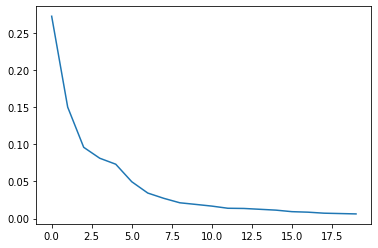

In [68]:
#fit the scaled dataset
pca_x = PCA().fit(X_features_scaled)

#plot explained variance ratio
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [69]:
pca_df = pd.DataFrame(pca_x.components_[0:20,].transpose(), columns = ["PC{}".format(i+1) for i in range(20)], \
                      index = X_features.columns)

In [70]:
#write for loop to make list "nth_principle_component"
princ_comp_list = []
for name in range(1,173):
    pr = str(name)+'th_pc'
    princ_comp_list.append(pr)    

In [71]:
#do split on 2 phases -- still need to do 3 phase split as well
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = princ_comp_list)
X_features_pca['YEAR'] = target_df['YEAR']

#split test and train on year
X_train_pca = X_features_pca[X_features_pca['YEAR']< 2016]
X_test_pca = X_features_pca[X_features_pca['YEAR']>=2016]

Y_train_pca = target_df[target_df['YEAR']<2016]['Y_bin_new_fire_month']
Y_train_size_pca = target_df[target_df['YEAR']<2016]['Y_max_new_fire_size_month']
Y_test_pca = target_df[target_df['YEAR']>=2016]['Y_bin_new_fire_month']
Y_test_size_pca = target_df[target_df['YEAR']>=2016]['Y_max_new_fire_size_month']

In [72]:
#do split on 3 phases -- still need to do 3 phase split as well
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = princ_comp_list)
X_features_pca['YEAR'] = target_df['YEAR']

#split phases on year
X_ph1_pca = X_features_pca[X_features_pca['YEAR']< 2006]
X_ph2_pca = X_features_pca[(X_features_pca['YEAR']>=2006)&(X_features_pca['YEAR']<2016)]
X_ph3_pca = X_features_pca[X_features_pca['YEAR']>=2016]


Y_ph1_pca = target_df[target_df['YEAR']<2006]['Y_bin_new_fire_month']
Y_ph1_size_pca = target_df[target_df['YEAR']<2006]['Y_max_new_fire_size_month']

Y_ph2_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_bin_new_fire_month']
Y_ph2_size_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_max_new_fire_size_month']

Y_ph3_pca = target_df[target_df['YEAR']>=2016]['Y_bin_new_fire_month']
Y_ph3_size_pca = target_df[target_df['YEAR']>=2016]['Y_max_new_fire_size_month']

# Test 5: Taking LR model-PCA, training on 1990-2015

use 'LR_15PCA_1990_2015.pkl' model <br>
use top 15 principle directions

In [73]:
#1. slim down features
X_tr_lrpca15 = X_train_pca[X_train_pca.columns[0:15]]
X_test_lrpca15 = X_test_pca[X_test_pca.columns[0:15]]

In [74]:
#2. run model on train and test sets to get predictions
y_preds_test5 = models['LR_15PCA_1990_2015.pkl'].predict(X_tr_lrpca15)
y_preds_5 = models['LR_15PCA_1990_2015.pkl'].predict(X_test_lrpca15)

In [75]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds5 = pd.DataFrame(y_preds_test5, columns=['preds'], index=X_tr_lrpca15.index)
X_tr_lrpca15_preds = X_tr_lrpca15.merge(preds5, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_tr_lrpca15_ysize = X_tr_lrpca15_preds.merge(Y_train_size_pca, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_tr_lrpca15_cut = X_tr_lrpca15_ysize.loc[X_tr_lrpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_size_pca_cut5 = X_tr_lrpca15_cut['Y_max_new_fire_size_month']
X_tr_lrpca15_ready = X_tr_lrpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [76]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_5 = pd.DataFrame(y_preds_5, columns=['preds'], index=X_test_lrpca15.index)
X_test_lrpca15_preds = X_test_lrpca15.merge(test_set_preds_5, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_test_lrpca15_ysize = X_test_lrpca15_preds.merge(Y_test_size_pca, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_test_lrpca15_cut = X_test_lrpca15_ysize.loc[X_test_lrpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_test_size_pca_cut5 = X_test_lrpca15_cut['Y_max_new_fire_size_month']
X_test_lrpca15_ready = X_test_lrpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])



In [77]:
#4. run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t5 = {}
aucs_lr_t5 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_lrpca15_ready, 
                                                                               Y_train_size_pca_cut5.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut5, lr.predict(X_test_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut5, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t5[c] = np.mean(aucs_sub)
    conf_mats_lr_t5[c] = cm

In [78]:
aucs_lr_t5

{0.0001: 0.6821713848641038,
 0.001: 0.694242118712571,
 0.01: 0.6940574180146195,
 0.1: 0.6939552893933996,
 1: 0.6939444246464611,
 10: 0.6939335598995229}

In [79]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t5 = {}
aucs_svm_t5 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_lrpca15_ready, 
                                                                               Y_train_size_pca_cut5.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut5, svm.predict(X_test_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut5, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t5[c] = np.mean(aucs_sub)
    conf_mats_svm_t5[c] = cm

In [80]:
aucs_svm_t5

{0.0001: 0.5790214774317477,
 0.001: 0.7104718776890249,
 0.01: 0.7257933438214357,
 0.1: 0.725836802809189,
 1: 0.7258585323030656,
 10: 0.7258737429487793}

### 5B. Same test data set and same features, only predicting on the actual positive instances

In [81]:
#filter for only the postitve instances (not positive preds)
X_tr_lrpca15_cut5 = X_tr_lrpca15_ysize.loc[X_tr_lrpca15_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_size_pca_cut5b = X_tr_lrpca15_cut5['Y_max_new_fire_size_month']
X_tr_lrpca15_ready2 = X_tr_lrpca15_cut5.drop(columns=['preds','Y_max_new_fire_size_month'])

In [82]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t5b = {}
aucs_lr_t5b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_lrpca15_ready2, 
                                                                               Y_train_size_pca_cut5b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut5, lr.predict(X_test_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut5, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t5b[c] = np.mean(aucs_sub)
    conf_mats_lr_t5b[c] = cm

In [83]:
aucs_lr_t5b

{0.0001: 0.5672247634092218,
 0.001: 0.5734422330813363,
 0.01: 0.5682113418913954,
 0.1: 0.5670424923113422,
 1: 0.5669036190939101,
 10: 0.5668804735576715}

In [84]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t5b = {}
aucs_svm_t5b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_lrpca15_ready2, 
                                                                               Y_train_size_pca_cut5b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut5, svm.predict(X_test_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut5, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t5b[c] = np.mean(aucs_sub)
    conf_mats_svm_t5b[c] = cm

In [85]:
aucs_svm_t5b

{0.0001: 0.46819369342001343,
 0.001: 0.5308978442826185,
 0.01: 0.5628213251398135,
 0.1: 0.5676153443332494,
 1: 0.568199769123276,
 10: 0.568269205731992}

# Test 6: Taking LR model-PCA, training on 2006-2015

use 'LR_15PCA_1990_2005.pkl' model <br>
use top 15 principle directions

In [86]:
#1. slim down features
X_ph1_lrpca15 = X_ph1_pca[X_train_pca.columns[0:15]]
X_ph2_lrpca15 = X_ph2_pca[X_train_pca.columns[0:15]]
X_ph3_lrpca15 = X_ph3_pca[X_train_pca.columns[0:15]]

In [87]:
#2. run model on train and test sets to get predictions
y_preds_test6 = models['LR_15PCA_1990_2005.pkl'].predict(X_ph2_lrpca15)
y_preds_6 = models['LR_15PCA_1990_2005.pkl'].predict(X_ph3_lrpca15)

In [88]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds6 = pd.DataFrame(y_preds_test6, columns=['preds'], index=X_ph2_lrpca15.index)
X_ph2_lrpca15_preds = X_ph2_lrpca15.merge(preds6, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph2_lrpca15_ysize = X_ph2_lrpca15_preds.merge(Y_ph2_size_pca, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_ph2_lrpca15_cut = X_ph2_lrpca15_ysize.loc[X_ph2_lrpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut = X_ph2_lrpca15_cut['Y_max_new_fire_size_month']
X_ph2_lrpca15_ready = X_ph2_lrpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [89]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_6 = pd.DataFrame(y_preds_6, columns=['preds'], index=X_ph3_lrpca15.index)
X_ph3_lrpca15_preds = X_ph3_lrpca15.merge(test_set_preds_6, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph3_lrpca15_ysize  = X_ph3_lrpca15_preds.merge(Y_ph3_size_pca, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_ph3_lrpca15_cut = X_ph3_lrpca15_ysize.loc[X_ph3_lrpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph3_size_pca_cut = X_ph3_lrpca15_cut['Y_max_new_fire_size_month']
X_ph3_lrpca15_ready = X_ph3_lrpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [90]:
#4. run LR on all Cs and store all confusion matrices and AUCs
aucs_lr_t6 = {}
conf_mats_lr_t6 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_lrpca15_ready, 
                                                                               Y_ph2_size_pca_cut.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut, lr.predict(X_ph3_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t6[c] = np.mean(aucs_sub)
    conf_mats_lr_t6[c] = cm

In [91]:
aucs_lr_t6

{0.0001: 0.6531414468307674,
 0.001: 0.6839123434997221,
 0.01: 0.6855141218005295,
 0.1: 0.6846233369291621,
 1: 0.6844128992187245,
 10: 0.684376123696512}

In [92]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t6 = {}
aucs_svm_t6 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_lrpca15_ready, 
                                                                               Y_ph2_size_pca_cut.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut, svm.predict(X_ph3_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t6[c] = np.mean(aucs_sub)
    conf_mats_svm_t6[c] = cm

In [93]:
aucs_svm_t6

{0.0001: 0.5007293811905462,
 0.001: 0.6771374750743682,
 0.01: 0.7241508940538066,
 0.1: 0.7268579811055539,
 1: 0.7270541172240201,
 10: 0.7270786342388283}

### 6B. Same test data set and same features, only predicting on the actual positive instances

In [94]:
#filter for only the postitve instances in the phase 2 set(not positive preds)
X_ph2_lrpca15_cut6 = X_ph2_lrpca15_ysize.loc[X_ph2_lrpca15_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut6b = X_ph2_lrpca15_cut6['Y_max_new_fire_size_month']
X_ph2_lrpca15_ready6 = X_ph2_lrpca15_cut6.drop(columns=['preds','Y_max_new_fire_size_month'])

In [95]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t6b = {}
aucs_lr_t6b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_lrpca15_ready6, 
                                                                               Y_ph2_size_pca_cut6b.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut, lr.predict(X_ph3_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t6b[c] = np.mean(aucs_sub)
    conf_mats_lr_t6b[c] = cm

In [96]:
aucs_lr_t6b

{0.0001: 0.5318417460996346,
 0.001: 0.5467648829549882,
 0.01: 0.5382054641891026,
 0.1: 0.5338739951127953,
 1: 0.5332038432934421,
 10: 0.5331139448786507}

In [97]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t6b = {}
aucs_svm_t6b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_lrpca15_ready6, 
                                                                               Y_ph2_size_pca_cut6b.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut, svm.predict(X_ph3_lrpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_lrpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t6b[c] = np.mean(aucs_sub)
    conf_mats_svm_t6b[c] = cm

In [98]:
aucs_svm_t6b

{0.0001: 0.44769682985499115,
 0.001: 0.4835063650801867,
 0.01: 0.5246634938882698,
 0.1: 0.5360261086790109,
 1: 0.5372765139029261,
 10: 0.5374263445942449}

# Test 7: Taking SVM model-PCA, training on 1990-2015

use 'linSVC_25PCA_1990_2015.pkl model <br>
use top 25 principle directions

In [99]:
#1. slim down features
X_tr_svmpca25 = X_train_pca[X_train_pca.columns[0:25]]
X_test_svmpca25 = X_test_pca[X_test_pca.columns[0:25]]

In [100]:
#2. run model on train and test sets to get predictions
y_preds_test7 = models['linSVC_25PCA_1990_2015.pkl'].predict(X_tr_svmpca25)
y_preds_7 = models['linSVC_25PCA_1990_2015.pkl'].predict(X_test_svmpca25)

In [101]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds7 = pd.DataFrame(y_preds_test7, columns=['preds'], index=X_tr_svmpca25.index)
X_tr_svmpca25_preds = X_tr_svmpca25.merge(preds5, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_tr_svmpca25_ysize = X_tr_svmpca25_preds.merge(Y_train_size_pca, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_tr_svmpca25_cut = X_tr_svmpca25_ysize.loc[X_tr_svmpca25_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_size_pca_cut7 = X_tr_svmpca25_cut['Y_max_new_fire_size_month']
X_tr_svmpca25_ready = X_tr_svmpca25_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [102]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_7 = pd.DataFrame(y_preds_7, columns=['preds'], index=X_test_svmpca25.index)
X_test_svmpca25_preds = X_test_svmpca25.merge(test_set_preds_7, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_test_svmpca25_ysize = X_test_svmpca25_preds.merge(Y_test_size_pca, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_test_svmpca25_cut = X_test_svmpca25_ysize.loc[X_test_svmpca25_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_test_size_pca_cut7 = X_test_svmpca25_cut['Y_max_new_fire_size_month']
X_test_svmpca25_ready = X_test_svmpca25_cut.drop(columns=['preds','Y_max_new_fire_size_month'])


In [103]:
#4. run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t7 = {}
aucs_lr_t7 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_svmpca25_ready, 
                                                                               Y_train_size_pca_cut7.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut7, lr.predict(X_test_svmpca25_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut7, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_svmpca25_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t7[c] = np.mean(aucs_sub)
    conf_mats_lr_t7[c] = cm

In [104]:
aucs_lr_t7

{0.0001: 0.6871411311201887,
 0.001: 0.7010643806455323,
 0.01: 0.7040676600886024,
 0.1: 0.7044147824252537,
 1: 0.7043956043956044,
 10: 0.7044205358341485}

In [105]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t7 = {}
aucs_svm_t7 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_svmpca25_ready, 
                                                                               Y_train_size_pca_cut7.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut7, svm.predict(X_test_svmpca25_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut7, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_svmpca25_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t7[c] = np.mean(aucs_sub)
    conf_mats_svm_t7[c] = cm
    

In [106]:
aucs_svm_t7

{0.0001: 0.586809351207257,
 0.001: 0.714843794948507,
 0.01: 0.7369330494984945,
 0.1: 0.737870855148342,
 1: 0.7379801699173426,
 10: 0.7379801699173427}

### 7B. Same test data set and same features, only predicting on the actual positive instances

In [107]:
#filter for only the postitve instances (not positive preds)
X_tr_svmpca25_cut7 = X_tr_svmpca25_ysize.loc[X_tr_lrpca15_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_train_size_pca_cut7b = X_tr_svmpca25_cut7['Y_max_new_fire_size_month']
X_tr_svmpca25_ready2 = X_tr_svmpca25_cut7.drop(columns=['preds','Y_max_new_fire_size_month'])

In [108]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t7b = {}
aucs_lr_t7b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_tr_svmpca25_ready2, 
                                                                               Y_train_size_pca_cut7b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut7, lr.predict(X_test_svmpca25_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut7, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_test_svmpca25_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t7b[c] = np.mean(aucs_sub)
    conf_mats_lr_t7b[c] = cm

In [109]:
aucs_lr_t7b

{0.0001: 0.5623877894456862,
 0.001: 0.5574057687094316,
 0.01: 0.5396592379656577,
 0.1: 0.5315340429558626,
 1: 0.5299560620553136,
 10: 0.5298460893183224}

In [110]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t7b = {}
aucs_svm_t7b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_tr_svmpca25_ready2, 
                                                                               Y_train_size_pca_cut7b.to_numpy().ravel())

    cm = confusion_matrix(Y_test_size_pca_cut7, svm.predict(X_test_svmpca25_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_test_size_pca_cut7, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_test_svmpca25_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t7b[c] = np.mean(aucs_sub)
    conf_mats_svm_t7b[c] = cm

In [111]:
aucs_svm_t7b

{0.0001: 0.4368321713733293,
 0.001: 0.4986087170017851,
 0.01: 0.5325698326879894,
 0.1: 0.5380249919438577,
 1: 0.538605545694951,
 10: 0.5386745983437595}

# Test 8: Taking SVM model-PCA, training on 2006-2015

use 'linSVC_15PCA_1990_2005.pkl' model <br>
use top 15 principle directions

In [112]:
#1. slim down features
X_ph1_svmpca15 = X_ph1_pca[X_train_pca.columns[0:15]]
X_ph2_svmpca15 = X_ph2_pca[X_train_pca.columns[0:15]]
X_ph3_svmpca15 = X_ph3_pca[X_train_pca.columns[0:15]]

In [113]:
#2. run model on train and test sets to get predictions
y_preds_test8 = models['linSVC_15PCA_1990_2005.pkl'].predict(X_ph2_svmpca15)
y_preds_8 = models['linSVC_15PCA_1990_2005.pkl'].predict(X_ph3_svmpca15)

In [114]:
#3. store predictions and filter

#append the these predictions to the dataframe
preds8 = pd.DataFrame(y_preds_test8, columns=['preds'], index=X_ph2_svmpca15.index)
X_ph2_svmpca15_preds = X_ph2_svmpca15.merge(preds8, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph2_svmpca15_ysize = X_ph2_svmpca15_preds.merge(Y_ph2_size_pca, how='outer', left_index=True, right_index=True)


#filter for the positive predicted instances
X_ph2_svmpca15_cut = X_ph2_svmpca15_ysize.loc[X_ph2_svmpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut8 = X_ph2_svmpca15_cut['Y_max_new_fire_size_month']
X_ph2_svmpca15_ready = X_ph2_svmpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [115]:
#3.5 need to score the test set and select only the positives to score on

#append the these predictions to the dataframe
test_set_preds_8 = pd.DataFrame(y_preds_8, columns=['preds'], index=X_ph3_svmpca15.index)
X_ph3_svmpca15_preds = X_ph3_svmpca15.merge(test_set_preds_8, how='outer', left_index=True, right_index=True)


#rejoin with the y-size column
X_ph3_svmpca15_ysize  = X_ph3_svmpca15_preds.merge(Y_ph3_size_pca, how='outer', left_index=True, right_index=True)


#filter for only positive predictions 
X_ph3_svmpca15_cut = X_ph3_svmpca15_ysize.loc[X_ph3_svmpca15_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph3_size_pca_cut8 = X_ph3_svmpca15_cut['Y_max_new_fire_size_month']
X_ph3_svmpca15_ready = X_ph3_svmpca15_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [116]:
#4. run LR on all Cs and store all confusion matrices and AUCs
aucs_lr_t8 = {}
conf_mats_lr_t8 = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_svmpca15_ready, 
                                                                               Y_ph2_size_pca_cut8.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut8, lr.predict(X_ph3_svmpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut8, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_svmpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t8[c] = np.mean(aucs_sub)
    conf_mats_lr_t8[c] = cm

In [117]:
aucs_lr_t8, conf_mats_lr_t8

({0.0001: 0.6739553214924962,
  0.001: 0.6976989536004407,
  0.01: 0.698635205837808,
  0.1: 0.6980380008261049,
  1: 0.6979777640093625,
  10: 0.6979708798017349},
 {0.0001: array([[0.46786042, 0.11707989, 0.19972452, 0.21533517],
         [0.23463687, 0.19832402, 0.30726257, 0.25977654],
         [0.18181818, 0.11038961, 0.35064935, 0.35714286],
         [0.15277778, 0.0787037 , 0.26388889, 0.50462963]]),
  0.001: array([[0.52892562, 0.10606061, 0.15794307, 0.20707071],
         [0.31005587, 0.15363128, 0.27653631, 0.25977654],
         [0.2012987 , 0.12337662, 0.30519481, 0.37012987],
         [0.16666667, 0.05555556, 0.25462963, 0.52314815]]),
  0.01: array([[0.55004591, 0.10284665, 0.14416896, 0.20293848],
         [0.31005587, 0.1452514 , 0.29608939, 0.24860335],
         [0.18181818, 0.12337662, 0.31818182, 0.37662338],
         [0.18981481, 0.0462963 , 0.26388889, 0.5       ]]),
  0.1: array([[0.55004591, 0.10192837, 0.14600551, 0.2020202 ],
         [0.31005587, 0.1452514 , 0.

In [118]:
#5. run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t8 = {}
aucs_svm_t8 = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_svmpca15_ready, 
                                                                               Y_ph2_size_pca_cut8.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut8, svm.predict(X_ph3_svmpca15_ready), normalize='true')
    
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut8, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_svmpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t8[c] = np.mean(aucs_sub)
    conf_mats_svm_t8[c] = cm

In [119]:
aucs_svm_t8, conf_mats_svm_t8

({0.0001: 0.5439900867410161,
  0.001: 0.7025712515489467,
  0.01: 0.7318893707834229,
  0.1: 0.7333815227867272,
  1: 0.7335587911331406,
  10: 0.7335846069117444},
 {0.0001: array([[0.89348026, 0.03627181, 0.02433425, 0.04591368],
         [0.88268156, 0.02793296, 0.03351955, 0.05586592],
         [0.87012987, 0.03896104, 0.04545455, 0.04545455],
         [0.85185185, 0.02777778, 0.02314815, 0.09722222]]),
  0.001: array([[0.9164371 , 0.02571166, 0.0174472 , 0.04040404],
         [0.84078212, 0.01396648, 0.06145251, 0.08379888],
         [0.74675325, 0.04545455, 0.07142857, 0.13636364],
         [0.69907407, 0.02777778, 0.06018519, 0.21296296]]),
  0.01: array([[0.90955005, 0.02112029, 0.02571166, 0.043618  ],
         [0.73463687, 0.03072626, 0.10335196, 0.13128492],
         [0.61038961, 0.06493506, 0.12987013, 0.19480519],
         [0.62037037, 0.03703704, 0.08333333, 0.25925926]]),
  0.1: array([[0.90312213, 0.02157943, 0.02800735, 0.04729109],
         [0.70949721, 0.03910615, 0

### 8B. Same test data set and same features, only predicting on the actual positive instances

In [120]:
#filter for only the postitve instances in the phase 2 set(not positive preds)
X_ph2_svmpca15_cut8 = X_ph2_svmpca15_ysize.loc[X_ph2_svmpca15_ysize['Y_max_new_fire_size_month']>0]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut8b = X_ph2_svmpca15_cut8['Y_max_new_fire_size_month']
X_ph2_svmpca15_ready8 = X_ph2_svmpca15_cut8.drop(columns=['preds','Y_max_new_fire_size_month'])

In [121]:
#run LR on all Cs and store all confusion matrices and AUCs
conf_mats_lr_t8b = {}
aucs_lr_t8b = {}
for c in cs:
    lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_svmpca15_ready8, 
                                                                               Y_ph2_size_pca_cut8b.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut8, lr.predict(X_ph3_svmpca15_ready), normalize='true')
    conf_mats_lr_t8b[c] = cm
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut8, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_svmpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_lr_t8b[c] = np.mean(aucs_sub)

In [122]:
aucs_lr_t8b

{0.0001: 0.5419930723346421,
 0.001: 0.5662139459377832,
 0.01: 0.5612565123829658,
 0.1: 0.5577053760193296,
 1: 0.557157958320749,
 10: 0.5570635759589248}

In [123]:
#run SVM on all Cs and store all confusion matrices and AUCs
conf_mats_svm_t8b = {}
aucs_svm_t8b = {}
for c in cs:
    svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_svmpca15_ready8, 
                                                                               Y_ph2_size_pca_cut8b.to_numpy().ravel())

    cm = confusion_matrix(Y_ph3_size_pca_cut8, svm.predict(X_ph3_svmpca15_ready), normalize='true')
    conf_mats_svm_t8b[c] = cm
    #store aucs -- will aggregate after taking an auc for each class -- simple mean
    y = label_binarize(Y_ph3_size_pca_cut8, classes=[0,1,2,3])
    n_classes = y.shape[1]
    aucs_sub = np.zeros(n_classes)
    for n in range(n_classes-1):
        fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_svmpca15_ready)[:,n])
        aucs_sub = auc(fpr,tpr)
    
    aucs_svm_t8b[c] = np.mean(aucs_sub)

In [124]:
aucs_svm_t8b

{0.0001: 0.44227810706735127,
 0.001: 0.49871639987919053,
 0.01: 0.5454710623678647,
 0.1: 0.5577808819087888,
 1: 0.5591588643914225,
 10: 0.5593311122017517}